In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.7, style="white")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

# Import cnn & basecalling data

In [4]:
run_to_include = ["08_09_2019_run_01",
                  "08_13_2019_run_02",
                  "08_13_2019_run_03",
                  "08_15_2019_run_02",
                  "08_15_2019_run_03",
                  "08_16_2019_run_01",
                  "08_28_2019_run_01",
                  "08_30_2019_run_01",
                  "09_05_2019_run_02"]

In [5]:
runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in run_to_include)]

In [6]:
label_df = []
for i, run_data in runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["model_v4_0_1_labeled_preds"]
    
    label_df_ = pd.read_csv(label_file, sep="\t", index_col=0)
    label_df_["run_name"] = run_name
    label_df.append(label_df_)
label_df = pd.concat(label_df)

In [10]:
all_df = []
for i, run_data in runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["model_v4_0_1_all_preds"]
    
    all_df_ = pd.read_csv(label_file, sep="\t", index_col=0)
    all_df_["run_name"] = run_name
    all_df.append(all_df_)
all_df = pd.concat(all_df)

In [11]:
all_df

,cnn_label,cnn_score,run_name
read_id,,,
00040c1e-94bc-4fdf-b475-1890a16a8f74,9,1.0,08_09_2019_run_01
00140655-b79c-481f-8f0f-a60c8d154611,3,1.0,08_09_2019_run_01
002af26c-b80e-4ba3-a820-13d0f5236bb0,10,1.0,08_09_2019_run_01
0045d3e8-014c-4e94-865f-012c398ccfdc,13,1.0,08_09_2019_run_01
00514395-8b77-4df9-b6ea-e09645b95985,7,1.0,08_09_2019_run_01
...,...,...,...
ff1c0290-ff89-4b1f-98e4-f954f6642cc3,26,1.0,09_05_2019_run_02
ff5d7b7d-701f-4b83-a132-583121028788,9,1.0,09_05_2019_run_02
ffeaddc5-e436-4dd8-8e06-e2b28303e5b2,40,1.0,09_05_2019_run_02


In [12]:
unlabeled_df = all_df.drop(label_df.index)

In [13]:
unlabeled_df

,cnn_label,cnn_score,run_name
read_id,,,
00568548-1d66-45a9-a4da-04a54e362157,5,1.000000,08_09_2019_run_01
0077ea18-894f-4cbc-a14d-6de48a9fa6a4,9,1.000000,08_09_2019_run_01
007b72a8-4347-47f3-9844-3c647f57abfa,9,1.000000,08_09_2019_run_01
007ffb06-ebf6-4cae-b784-9a34323ba56c,5,1.000000,08_09_2019_run_01
00f50bef-8b51-4b6f-bdb6-3d5ba12077c7,9,1.000000,08_09_2019_run_01
...,...,...,...
fbc0be53-6c7e-43d6-9333-8d291c2dcfe0,9,1.000000,09_05_2019_run_02
fc2269eb-6e84-4c3f-8f6b-f559055f251a,85,0.999933,09_05_2019_run_02
fc539ebf-6b03-40fc-9abe-ca3cb2957274,86,1.000000,09_05_2019_run_02


# Get cnn & basecalling read counts

In [7]:
label_df

,cnn_label,cnn_score,sw_label,run_name
read_id,,,,
00040c1e-94bc-4fdf-b475-1890a16a8f74,12,1.000000,12,08_09_2019_run_01
00140655-b79c-481f-8f0f-a60c8d154611,5,1.000000,5,08_09_2019_run_01
002af26c-b80e-4ba3-a820-13d0f5236bb0,15,1.000000,15,08_09_2019_run_01
0045d3e8-014c-4e94-865f-012c398ccfdc,12,0.999992,12,08_09_2019_run_01
00514395-8b77-4df9-b6ea-e09645b95985,15,1.000000,15,08_09_2019_run_01
...,...,...,...,...
fec84f3d-dfa1-43d0-a42a-f4674b963e16,54,1.000000,54,09_05_2019_run_02
ff1c0290-ff89-4b1f-98e4-f954f6642cc3,61,1.000000,61,09_05_2019_run_02
ff5d7b7d-701f-4b83-a132-583121028788,84,1.000000,84,09_05_2019_run_02


In [9]:
np.unique(label_df["sw_label"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [8]:
sum(label_df["sw_label"] == -1)

0

In [15]:
# counts_cnn = []
counts_sw = []
for run_name, df in label_df.groupby("run_name"):
    print(run_name)
#     l_cnn, c_cnn = np.unique(df["cnn_label"], return_counts=True)
    l_sw, c_sw = np.unique(df["sw_label"], return_counts=True)
#     l_cnn = list(l_cnn)
    l_sw = list(l_sw)
    
    for molbit in range(96):
#         try:
#             i_cnn = l_cnn.index(molbit)
#             c = c_cnn[i_cnn]
#         except ValueError:
#             c = 0 
#         counts_cnn.append(c)
        
        try:
            i_sw = l_sw.index(molbit)
            c = c_sw[i_sw]
        except ValueError:
            c = 0
        counts_sw.append(c)
    

08_09_2019_run_01
08_13_2019_run_02
08_13_2019_run_03
08_15_2019_run_02
08_15_2019_run_03
08_16_2019_run_01
08_28_2019_run_01
08_30_2019_run_01
09_05_2019_run_02


In [16]:
counts_cnn = []
# counts_sw = []
for run_name, df in unlabeled_df.groupby("run_name"):
    print(run_name)
    l_cnn, c_cnn = np.unique(df["cnn_label"], return_counts=True)
    l_cnn = list(l_cnn)
    
    for molbit in range(96):
        try:
            i_cnn = l_cnn.index(molbit)
            c = c_cnn[i_cnn]
        except ValueError:
            c = 0 
        counts_cnn.append(c)
    
    

08_09_2019_run_01
08_13_2019_run_02
08_13_2019_run_03
08_15_2019_run_02
08_15_2019_run_03
08_16_2019_run_01
08_28_2019_run_01
08_30_2019_run_01
09_05_2019_run_02


In [17]:
max(counts_sw)

75466

[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos
[09:09:43 - matplotlib.axes._base] update_title_pos


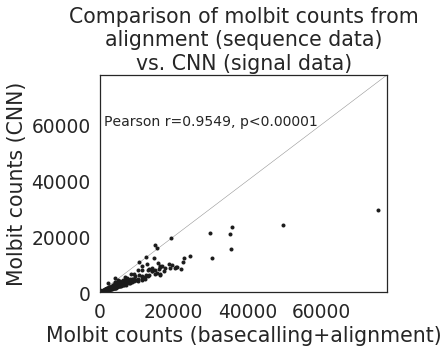

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
edge = 78000
plt.plot([0, edge], [0, edge], linewidth=0.5, color="k", alpha=0.5)
ax.scatter(counts_sw, counts_cnn, c="k", marker=".")
ax.set_xlabel("Molbit counts (basecalling+alignment)")
ax.set_ylabel("Molbit counts (CNN)")
r, p = pearsonr(counts_sw, counts_cnn)
ax.text(1000, 60000, f"Pearson r={r:.4f}, p<{p:.4f}1", fontsize=14)
ax.set_xlim([0, edge])
ax.set_ylim([0, edge])
ax.set_title("Comparison of molbit counts from\nalignment (sequence data)\nvs. CNN (signal data)")
plt.tight_layout()
plt.savefig("../v4/plots/read_counts_seq_vs_squig.svg")

In [19]:
r

0.9549138547910597

In [21]:
p

0.0

In [20]:
ax.get_ylim()[1]

78000.0